In [51]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

In [52]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [53]:
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [54]:
## Define the state
class AgentState(MessagesState):
    next_agent:str #which agent should go next 

In [55]:
# Create simple tools
@tool
def search_web(query: str) -> str:
    """Search the web for information."""
    # Using Tavily for web search
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content: str) -> str:
    """Write a summary of the provided content."""
    # Simple summary generation
    summary = f"Summary of findings:\n\n{content[:500]}..."
    return summary

In [56]:

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027D70110A50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027D70111450>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [57]:
# Define agent functions (simpler approach)
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    
    messages = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to find information about the user's request.")
    
    # Call LLM with tools
    researcher_llm = llm.bind_tools([search_web])
    response = researcher_llm.invoke([system_msg] + messages)
    
    # Return the response and route to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [58]:
def writer_agent(state: AgentState):
    """Writer agent that creates summaries"""
    
    messages = state["messages"]
    
    # Add system message
    system_msg = SystemMessage(content="You are a technical writer. Review the conversation and create a clear, concise summary of the findings.")
    
    # Simple completion without tools
    response = llm.invoke([system_msg] + messages)
    
    return {
        "messages": [response],
        "next_agent": "end"
    }

In [59]:
# We will check if any tool call needs to be made or not
# Tool executor node
def execute_tools(state: AgentState):
    """Execute any pending tool calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        # Create tool node and execute
        tool_node = ToolNode([search_web, write_summary])
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state


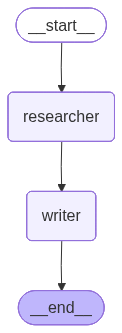

In [60]:
# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow=workflow.compile()

final_workflow

In [61]:
response=final_workflow.invoke({"messages":"Reasearch about the usecase of agentic ai in business"})


In [62]:
response["messages"][-1].content


''

# supervise Multi Ai Agent Architecture


In [63]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [64]:
# ===================================
# State Definition
# ===================================

# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

What This Does:

Creates a prompt chain where:

System message: tells the LLM what its role is.

Human message: passes in the current task description from the user.

In [65]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [66]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"] #state["messages"] contains all previous chat messages (conversation history).
    task = messages[-1].content if messages else "No task" #It takes the latest message as the current task.
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower() #remove whitespaces and convert to lowercase
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
#The new supervisor message is added to conversation history.
#next_agent tells LangGraph which node to call next.
#current_task tracks the task being processed.

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [67]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    #Reads the task from SupervisorState. If no task is set yet, it defaults to "research topic".
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)], #Adds the research summary to the conversation log.
        "research_data": research_data, #Stores full research results (used later by Analyst).
        "next_agent": "supervisor"
    }


In [68]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message - prepare a human readable message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }


In [69]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [70]:
# ===================================
# Router Function
# ===================================

#In a LangGraph, a router is basically a switch that decides which "edge" or "node" to follow next.
def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    #If somehow next_agent was something unknown, it falls back to supervisor.
    return "supervisor"

In [71]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

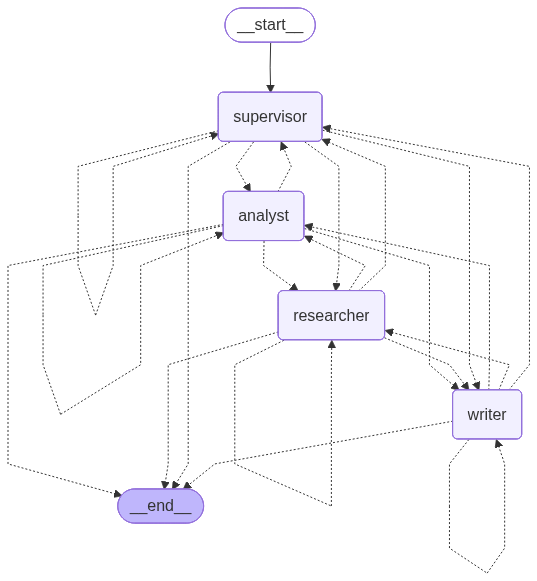

In [72]:
graph

In [73]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))


researcher
analyst
writer


In [74]:
response['final_report']


'\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-09-18 23:44\nTopic: 📊 Analyst: I\'ve completed the analysis.\n\nTop insights:\nIt appears there\'s no specific task or topic to work on. However, I can provide some general insights based on the provided template.\n\nSince there\'s no actual data to analyze, I\'ll create a hypothetical scenario to demonstrate how I would approach the task. Let\'s assume the topic is "The Impact of Artificial Intelligence on the Job Market."\n\n**Hypothetical Research Data:**\n\n* Key Facts and Backgro...\n==================================================\n\n**Executive Report: The Impact of Artificial Intelligence on the Job Market**\n\n**Executive Summary**\n\nThis report provides an analysis of the impact of artificial intelligence (AI) on the job market. Based on hypothetical research data, we have identified key trends, statistics, and notable examples that highlight the implications of AI on employment. Our fin

'\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-09-18 23:44\nTopic: 📊 Analyst: I\'ve completed the analysis.\n\nTop insights:\nIt appears there\'s no specific task or topic to work on. However, I can provide some general insights based on the provided template.\n\nSince there\'s no actual data to analyze, I\'ll create a hypothetical scenario to demonstrate how I would approach the task. Let\'s assume the topic is "The Impact of Artificial Intelligence on the Job Market."\n\n**Hypothetical Research Data:**\n\n* Key Facts and Backgro...\n==================================================\n\n**Executive Report: The Impact of Artificial Intelligence on the Job Market**\n\n**Executive Summary**\n\nThis report provides an analysis of the impact of artificial intelligence (AI) on the job market. Based on hypothetical research data, we have identified key trends, statistics, and notable examples that highlight the implications of AI on employment. Our findings suggest that AI is transforming the job market, leading to both positive and negative consequences. We recommend that businesses and policymakers take proactive steps to mitigate the negative effects and harness the benefits of AI.\n\n**Key Findings**\n\n1. **Job Displacement**: Our research indicates that AI is likely to displace certain jobs, particularly those that involve routine, repetitive, or predictable tasks.\n2. **New Job Creation**: However, AI is also expected to create new job opportunities in fields such as AI development, deployment, and maintenance.\n3. **Skills Gap**: The increasing use of AI is creating a skills gap, as workers need to acquire new skills to remain employable in an AI-driven job market.\n4. **Industry Disruption**: AI is disrupting various industries, including customer service, finance, and healthcare, leading to changes in business models and job roles.\n\n**Analysis & Insights**\n\nOur analysis suggests that the impact of AI on the job market is multifaceted and complex. On one hand, AI is automating many tasks, leading to increased productivity and efficiency. On the other hand, it is also displacing jobs and creating a skills gap. To mitigate the negative effects, businesses and policymakers must invest in education and training programs that equip workers with the skills needed to thrive in an AI-driven job market.\n\n**Recommendations**\n\n1. **Upskilling and Reskilling**: Businesses and policymakers should invest in education and training programs that help workers develop the skills needed to work with AI.\n2. **Emphasis on Human Skills**: There should be an emphasis on developing human skills, such as creativity, critical thinking, and emotional intelligence, which are less likely to be automated.\n3. **Social Safety Nets**: Governments should establish social safety nets to support workers who lose their jobs due to AI displacement.\n4. **Encouraging AI Adoption**: Businesses should encourage the adoption of AI to create new job opportunities and drive innovation.\n\n**Conclusion**\n\nIn conclusion, the impact of AI on the job market is significant and far-reaching. While AI is likely to displace certain jobs, it is also expected to create new job opportunities and drive innovation. To mitigate the negative effects, businesses and policymakers must invest in education and training programs, emphasize human skills, and establish social safety nets. By taking proactive steps, we can harness the benefits of AI and create a more inclusive and equitable job market.\n\n==================================================\nReport compiled by Multi-Agent AI System powered by Groq\n'

In [75]:
response

{'messages': [AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='c9a6337f-47bc-4231-9f69-1a71add56812'),
  AIMessage(content="🔍 Researcher: I've completed the research on 'No task'.\n\nKey findings:\nIt appears there is no task or topic provided. \n\nHowever, I can provide a general template for the information you requested:\n\n**Template for Comprehensive Information**\n\n1. **Key Facts and Background**\n   - Brief overview of the topic\n   - Historical context or development\n\n2. **Current Trends or Developments**\n   - Recent advancements or breakthroughs\n   - Emerging technologies or innovations\n   - Shifts in industry or market trends\n\n3. **Important Statistics or Data Points**\n   - Relevant num...", additional_kwargs={}, response_metadata={}, id='57582473-b648-4d3c-83cb-ee3e75a3cfe9'),
  AIMessage(content='📋 Supervisor: Research done. Time for analysis. Assigning to Analyst...', additiona